# Nixtla Suite for Time Series Forecasting with Python

In [7]:
!pip install statsforecast
!pip install neuralforecast
!pip install mlforecast
!pip install hierarchicalforecast
!pip install datasetsforecast

^C
Fatal Python error: init_import_size: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/jnesnky/opt/anaconda3/lib/python3.8/site.py", line 580, in <module>
    main()
  File "/Users/jnesnky/opt/anaconda3/lib/python3.8/site.py", line 573, in main
    execsitecustomize()
  File "/Users/jnesnky/opt/anaconda3/lib/python3.8/site.py", line 512, in execsitecustomize
    import sitecustomize
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 914, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1342, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1314, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1443, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1483, in _fill_cache
KeyboardInterrupt
^C
Traceback (most rec

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Forecasts:
  unique_id         ds  AutoARIMA
0   series1 2023-01-01  89.755283
1   series1 2023-01-02  89.755283
2   series1 2023-01-03  89.755283
3   series1 2023-01-04  89.755283
4   series1 2023-01-05  89.755283


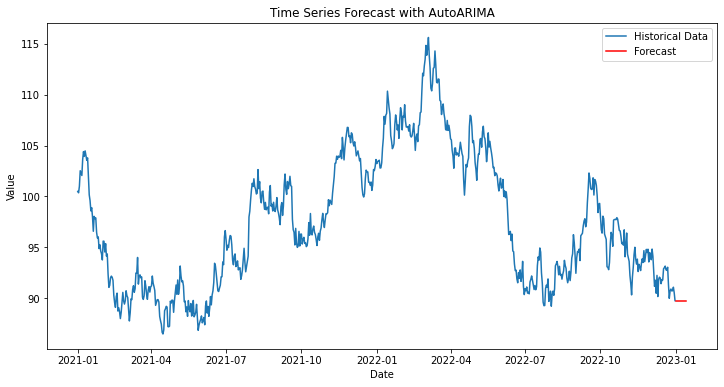


Forecast Metrics:
Mean Squared Error (MSE): 4.27
Root Mean Squared Error (RMSE): 2.07
Mean Absolute Error (MAE): 1.70


In [40]:
import os
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt

# Set the environment variable to adopt the new behavior
os.environ['NIXTLA_ID_AS_COL'] = '1'

# Create a sample time series dataset
np.random.seed(42)
dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')
values = np.cumsum(np.random.randn(len(dates))) + 100  # Random walk

df = pd.DataFrame({
    'unique_id': 'series1',
    'ds': dates,
    'y': values
})

# Initialize the StatsForecast model
models = [AutoARIMA(season_length=7)]
sf = StatsForecast(models=models, freq='D', n_jobs=-1)

# Fit the model and generate forecasts
horizon = 14
forecasts = sf.forecast(df=df, h=horizon)

print("Forecasts:")
print(forecasts.head())

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data')

# Check if 'unique_id' is in the columns (new behavior)
if 'unique_id' in forecasts.columns:
    forecasts = forecasts[forecasts['unique_id'] == 'series1']

plt.plot(forecasts['ds'], forecasts['AutoARIMA'], label='Forecast', color='red')
plt.title('Time Series Forecast with AutoARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig("AutoARIMA.png")
plt.show()

# Calculate and print forecast metrics
actual_values = df.iloc[-horizon:]
forecast_values = forecasts['AutoARIMA']

mse = np.mean((actual_values['y'].values - forecast_values.values) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_values['y'].values - forecast_values.values))

print(f"\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


In [47]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    """Fetch data from FRED API."""
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': datetime.now().strftime('%Y-%m-%d'),
    }
    url = "https://api.stlouisfed.org/fred/series/observations"
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        observations = data['observations']
        df = pd.DataFrame(observations)
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')  # Convert to numeric, setting invalid values to NaN
        df = df.dropna(subset=['value'])  # Remove rows with NaN values in 'value' column
        df = df.sort_values('date')
        df = df[['date', 'value']]  # Keep only 'date' and 'value' columns
        df['unique_id'] = 0  # Add unique_id column
        return df
    else:
        raise Exception(f"API request failed with status code {response.status_code}")

# Fetch data from FRED
series_id = 'GDPC1'  # Real GDP series
df = fetch_fred_data(series_id, api_key)

# Rename columns to match StatsForecast expectations
df = df.rename(columns={'date': 'ds', 'value': 'y'})

# Initialize the StatsForecast model
models = [AutoARIMA(season_length=4)]  # Assuming quarterly data for GDP
sf = StatsForecast(models=models, freq='Q', n_jobs=-1)

# Fit the model and generate forecasts
sf.fit(df)
forecasts = sf.forecast(h=4, df=df)  # Forecast the next 4 quarters
print(forecasts.head())


   unique_id         ds     AutoARIMA
0          0 2024-09-30  23514.607549
1          0 2024-12-31  23565.164677
2          0 2025-03-31  23563.685018
3          0 2025-06-30  23747.949650


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 95, number of used features: 5
[LightGBM] [Info] Start training from score 18149.648931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

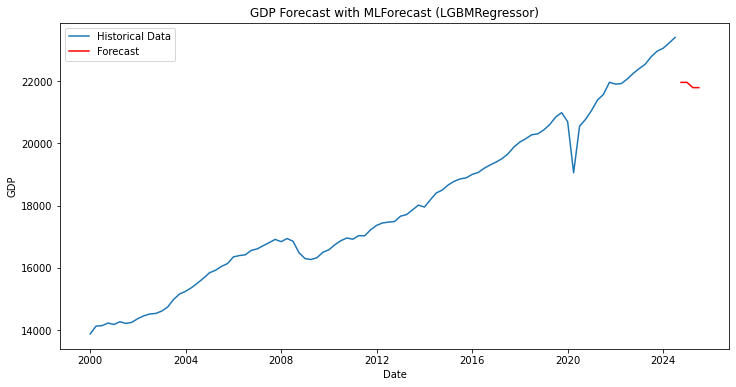


Forecast Metrics:
Mean Squared Error (MSE): 1715185.62
Root Mean Squared Error (RMSE): 1309.65
Mean Absolute Error (MAE): 1286.11


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlforecast import MLForecast
from lightgbm import LGBMRegressor

# Assuming df is your FRED data DataFrame
# If it's not already in the correct format, you might need to preprocess it
df = df.rename(columns={'date': 'ds', 'value': 'y'})
df['unique_id'] = 'GDPC1'  # Add a unique identifier for the series

# Initialize the MLForecast model
model = MLForecast(
    models=[LGBMRegressor()],
    freq='Q',  # Change to quarterly frequency for GDP data
    lags=[1, 2, 4],  # Adjust lags for quarterly data
    date_features=['quarter', 'year']
)

# Fit the model
model.fit(df)

# Generate forecasts
horizon = 4  # Forecast next 4 quarters
forecasts = model.predict(horizon)

print("Forecasts:")
print(forecasts.head())
print("\nForecast columns:")
print(forecasts.columns)

# Prepare data for visualization
historical_data = df
forecast_data = forecasts

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(historical_data['ds'], historical_data['y'], label='Historical Data')
plt.plot(forecast_data['ds'], forecast_data['LGBMRegressor'], label='Forecast', color='red')
plt.title('GDP Forecast with MLForecast (LGBMRegressor)')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.show()

# Calculate and print forecast metrics
actual_values = historical_data.iloc[-horizon:]
forecast_values = forecast_data['LGBMRegressor']

mse = np.mean((actual_values['y'].values - forecast_values.values) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_values['y'].values - forecast_values.values))

print(f"\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


In [52]:
"""
HierarchicalForecast: Hierarchical Time Series
HierarchicalForecast provides tools for forecasting hierarchical and grouped time series, ensuring coherence across different aggregation levels.
Example: Hierarchical Forecasting
"""


import pandas as pd
import numpy as np
from hierarchicalforecast.models import HierarchicalForecast
from hierarchicalforecast.utils import agg_series
from hierarchicalforecast.methods import BottomUp
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df is your FRED GDP DataFrame
# If it's not already in the correct format, you might need to preprocess it
df = df.rename(columns={'date': 'ds', 'value': 'y'})
df['ds'] = pd.to_datetime(df['ds'])

# Create a simple hierarchy for demonstration
df['Total'] = 'GDP'
df['Region'] = np.random.choice(['East', 'West'], size=len(df))
df['State'] = np.random.choice(['State1', 'State2', 'State3', 'State4'], size=len(df))
df['unique_id'] = df['State']

# Define the hierarchy
S = {
    'GDP': ['East', 'West'],
    'East': ['State1', 'State2'],
    'West': ['State3', 'State4']
}

# Visualize the hierarchy
G = nx.DiGraph(S)
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, arrows=True)
plt.title("Hierarchical Structure of GDP")
plt.show()

# Aggregate the series
Y_df, S_df = agg_series(df, S)

# Initialize the model
hf_model = HierarchicalForecast(
    model=AutoARIMA(),
    reconciliation=BottomUp()
)

# Fit and forecast
hf_model.fit(Y_df=Y_df, S=S_df, freq='Q')  # Change to quarterly frequency
forecasts = hf_model.predict(h=4)  # Forecast 4 quarters ahead
print("Forecasts:")
print(forecasts.head())

# Plot forecasts for different levels
fig, axs = plt.subplots(3, 1, figsize=(12, 15))
levels = ['GDP', 'East', 'State1']

for i, level in enumerate(levels):
    historical = Y_df[Y_df['unique_id'] == level]
    forecast = forecasts[forecasts['unique_id'] == level]
    
    axs[i].plot(historical['ds'], historical['y'], label='Historical')
    axs[i].plot(forecast['ds'], forecast['y'], label='Forecast', color='red')
    axs[i].set_title(f'Forecast for {level}')
    axs[i].legend()
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('GDP')

plt.tight_layout()
plt.show()

# Evaluate model performance
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return mae, rmse

# Assuming the last 4 periods are our test set
test_periods = 4
evaluation_results = {}

for level in Y_df['unique_id'].unique():
    actual = Y_df[Y_df['unique_id'] == level]['y'].iloc[-test_periods:]
    forecast = forecasts[forecasts['unique_id'] == level]['y']
    mae, rmse = evaluate_forecast(actual, forecast)
    evaluation_results[level] = {'MAE': mae, 'RMSE': rmse}

print("\nEvaluation Results:")
print(pd.DataFrame(evaluation_results).T)


ModuleNotFoundError: No module named 'hierarchicalforecast.models'

In [35]:
import pandas as pd
from hierarchicalforecast.models import HierarchicalForecast
from hierarchicalforecast.utils import agg_series
from hierarchicalforecast.methods import BottomUp
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt
import networkx as nx

# Load sample hierarchical data
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/hierarchicalforecast/main/datasets/WeeklyHierarchicalDataset.csv')
df['ds'] = pd.to_datetime(df['ds'])

# Define the hierarchy
S = {
    'Total': ['A', 'B', 'C'],
    'A': ['A1', 'A2'],
    'B': ['B1', 'B2'],
    'C': ['C1', 'C2']
}

# Visualize the hierarchy
G = nx.DiGraph(S)
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, arrows=True)
plt.title("Hierarchical Structure")
plt.show()

# Aggregate the series
Y_df, S_df = agg_series(df, S)

# Initialize the model
hf_model = HierarchicalForecast(
    model=AutoARIMA(),
    reconciliation=BottomUp()
)

# Fit and forecast
hf_model.fit(Y_df=Y_df, S=S_df, freq='W')
forecasts = hf_model.predict(h=4)
print("Forecasts:")
print(forecasts.head())

# Plot forecasts for different levels
fig, axs = plt.subplots(3, 1, figsize=(12, 15))
levels = ['Total', 'A', 'A1']

for i, level in enumerate(levels):
    historical = Y_df[Y_df['unique_id'] == level]
    forecast = forecasts[forecasts['unique_id'] == level]
    
    axs[i].plot(historical['ds'], historical['y'], label='Historical')
    axs[i].plot(forecast['ds'], forecast['y'], label='Forecast', color='red')
    axs[i].set_title(f'Forecast for {level}')
    axs[i].legend()
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return mae, rmse

# Assuming the last 4 periods are our test set
test_periods = 4
evaluation_results = {}

for level in Y_df['unique_id'].unique():
    actual = Y_df[Y_df['unique_id'] == level]['y'].iloc[-test_periods:]
    forecast = forecasts[forecasts['unique_id'] == level]['y']
    mae, rmse = evaluate_forecast(actual, forecast)
    evaluation_results[level] = {'MAE': mae, 'RMSE': rmse}

print("\nEvaluation Results:")
print(pd.DataFrame(evaluation_results).T)


ModuleNotFoundError: No module named 'hierarchicalforecast.models'

In [36]:
import hierarchicalforecast
print(hierarchicalforecast.__version__)


0.4.2


In [37]:
import pandas as pd
from hierarchicalforecast.core import HierarchicalForecast
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp
from statsforecast.models import AutoARIMA

# Load sample hierarchical data
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/hierarchicalforecast/main/datasets/WeeklyHierarchicalDataset.csv')
df['ds'] = pd.to_datetime(df['ds'])

# Define the hierarchy
S = {
    'Total': ['A', 'B', 'C'],
    'A': ['A1', 'A2'],
    'B': ['B1', 'B2'],
    'C': ['C1', 'C2']
}

# Initialize the model
hf_model = HierarchicalForecast(
    model=AutoARIMA(),
    reconciliation=BottomUp()
)

# Fit and forecast
hf_model.fit(df, S)
forecasts = hf_model.predict(h=4)
print("Forecasts:")
print(forecasts.head())

# Evaluate the model
evaluator = HierarchicalEvaluation(models=[hf_model], df=df, S=S)
evaluation = evaluator.evaluate(test_method='last4', metrics=['mae', 'rmse'])
print("\nEvaluation Results:")
print(evaluation)

# Visualize forecasts for different levels
import matplotlib.pyplot as plt

levels = ['Total', 'A', 'A1']
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

for i, level in enumerate(levels):
    historical = df[df['unique_id'] == level]
    forecast = forecasts[forecasts['unique_id'] == level]
    
    axs[i].plot(historical['ds'], historical['y'], label='Historical')
    axs[i].plot(forecast['ds'], forecast['y'], label='Forecast', color='red')
    axs[i].set_title(f'Forecast for {level}')
    axs[i].legend()
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Value')

plt.tight_layout()
plt.show()


ImportError: cannot import name 'HierarchicalForecast' from 'hierarchicalforecast.core' (/Users/jnesnky/opt/anaconda3/lib/python3.8/site-packages/hierarchicalforecast/core.py)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 716, number of used features: 5
[LightGBM] [Info] Start training from score 97.333999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

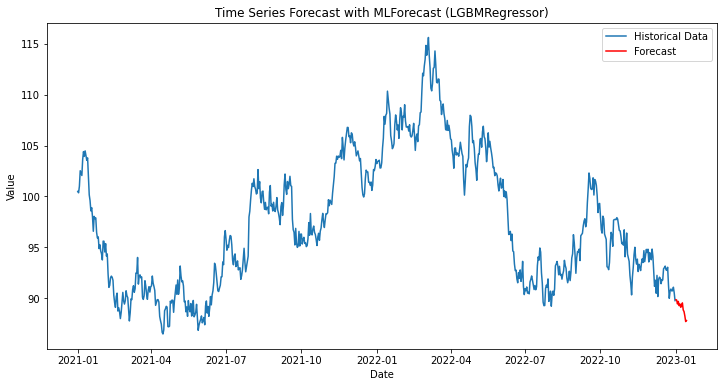


Forecast Metrics:
Mean Squared Error (MSE): 6.57
Root Mean Squared Error (RMSE): 2.56
Mean Absolute Error (MAE): 2.42


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlforecast import MLForecast
from lightgbm import LGBMRegressor

# Create sample data
np.random.seed(42)
dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')
values = np.cumsum(np.random.randn(len(dates))) + 100  # Random walk
df = pd.DataFrame({
    'unique_id': 'series1',
    'ds': dates,
    'y': values
})

# Initialize the MLForecast model
model = MLForecast(
    models=[LGBMRegressor()],
    freq='D',
    lags=[1, 7, 14],
    date_features=['dayofweek', 'day']
)

# Fit the model
model.fit(df)

# Generate forecasts
horizon = 14
forecasts = model.predict(horizon)

print("Forecasts:")
print(forecasts.head())
print("\nForecast columns:")
print(forecasts.columns)

# Prepare data for visualization
historical_data = df[df['unique_id'] == 'series1']
forecast_data = forecasts[forecasts['unique_id'] == 'series1']

# Use the correct column name for predictions
prediction_col = 'LGBMRegressor'

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(historical_data['ds'], historical_data['y'], label='Historical Data')
plt.plot(forecast_data['ds'], forecast_data[prediction_col], label='Forecast', color='red')
plt.title('Time Series Forecast with MLForecast (LGBMRegressor)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate and print forecast metrics
actual_values = historical_data.iloc[-horizon:]
forecast_values = forecast_data[prediction_col]

mse = np.mean((actual_values['y'].values - forecast_values.values) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_values['y'].values - forecast_values.values))

print(f"\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


In [33]:
"""
Parallel Computing and Scalability
The Nixtla suite leverages parallel computing to speed up forecasting tasks:
n_jobs: Parameter to set the number of parallel jobs.
Dask Integration: For distributed computing across clusters.
"""

# In StatsForecast, set n_jobs to -1 to use all available CPUs
sf = StatsForecast(df=df, models=models, freq='D', n_jobs=-1)


/Users/jnesnky/opt/anaconda3/lib/python3.8/site-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP

np.random.seed(42)
dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')
values = np.cumsum(np.random.randn(len(dates))) + 100  # Random walk
df = pd.DataFrame({
     'unique_id': 'series1',
     'ds': dates,
     'y': values
 })
# Initialize the NeuralForecast model
horizon = 14
model = MLP(h=horizon, input_size=28)  # 28 days of history
nf = NeuralForecast(models=[model], freq='D')

# Fit the model
nf.fit(df)

# Generate forecasts
forecasts = nf.predict()

print("\nForecasts:")
print(forecasts.head())

# Prepare data for visualization
historical_data = df[df[id_col] == df[id_col].unique()[0]]
forecast_data = forecasts[forecasts['unique_id'] == df[id_col].unique()[0]]

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(historical_data[time_col], historical_data[target_col], label='Historical Data')
plt.plot(forecast_data['ds'], forecast_data['MLP'], label='Forecast', color='red')
plt.title('Time Series Forecast with NeuralForecast (MLP)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate and print forecast metrics
actual_values = historical_data.iloc[-horizon:]
forecast_values = forecast_data['MLP']

mse = np.mean((actual_values[target_col].values - forecast_values.values) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_values[target_col].values - forecast_values.values))

print(f"\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 14.3 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.375     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


ValueError: 
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.

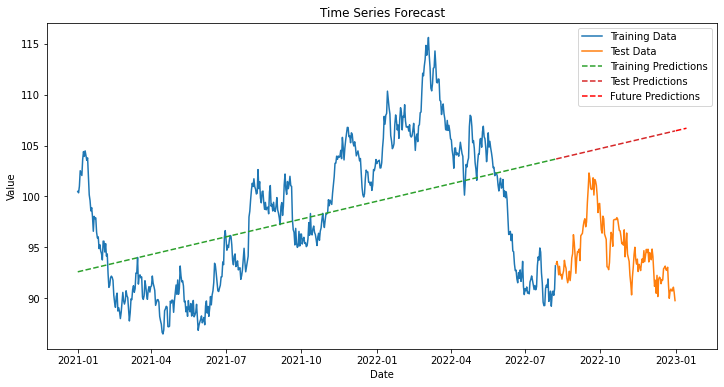


Forecast Metrics:
Mean Squared Error (MSE): 118.68
Root Mean Squared Error (RMSE): 10.89
Mean Absolute Error (MAE): 10.39


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Generate sample data
np.random.seed(42)
dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')
values = np.cumsum(np.random.randn(len(dates))) + 100  # Random walk
df = pd.DataFrame({
    'ds': dates,
    'y': values
})

# Prepare features
df['date_ordinal'] = pd.to_datetime(df['ds']).map(lambda x: x.toordinal())

# Split the data
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Prepare X and y for the model
X_train = train[['date_ordinal']]
y_train = train['y']
X_test = test[['date_ordinal']]
y_test = test['y']

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Prepare data for future predictions
future_dates = pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), periods=14, freq='D')
future_df = pd.DataFrame({'ds': future_dates})
future_df['date_ordinal'] = pd.to_datetime(future_df['ds']).map(lambda x: x.toordinal())
future_pred = model.predict(future_df[['date_ordinal']])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Test Data')
plt.plot(train['ds'], train_pred, label='Training Predictions', linestyle='--')
plt.plot(test['ds'], test_pred, label='Test Predictions', linestyle='--')
plt.plot(future_df['ds'], future_pred, label='Future Predictions', linestyle='--', color='red')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate and print forecast metrics
mse = np.mean((y_test - test_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - test_pred))

print(f"\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, NHITS
import pytorch_lightning as pl

# Disable logging to avoid the error
pl.utilities.rank_zero.rank_zero_only.rank = -1

# Generate sample data
np.random.seed(42)
dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')
values = np.cumsum(np.random.randn(len(dates))) + 100  # Random walk
df = pd.DataFrame({
    'unique_id': 'series1',
    'ds': dates,
    'y': values
})

# Set the forecast horizon
horizon = 14

# Initialize the NeuralForecast models
models = [
    MLP(h=horizon, input_size=30, trainer_kwargs={"logger": False}),
    NHITS(h=horizon, input_size=30, trainer_kwargs={"logger": False})
]

# Create the NeuralForecast object
nf = NeuralForecast(models=models, freq='D')

# Fit the model
nf.fit(df)

# Generate forecasts
forecasts = nf.predict()

# Prepare data for visualization
historical_data = df[df['unique_id'] == df['unique_id'].unique()[0]]
forecast_data = forecasts[forecasts['unique_id'] == df['unique_id'].unique()[0]]

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(historical_data['ds'], historical_data['y'], label='Historical Data')
plt.plot(forecast_data['ds'], forecast_data['MLP'], label='MLP Forecast', color='red')
plt.plot(forecast_data['ds'], forecast_data['NHITS'], label='NHITS Forecast', color='green')
plt.title('Time Series Forecast with NeuralForecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate and print forecast metrics
actual_values = historical_data.iloc[-horizon:]['y'].values
mlp_forecast = forecast_data['MLP'].values
nhits_forecast = forecast_data['NHITS'].values

def calculate_metrics(actual, forecast):
    mse = np.mean((actual - forecast) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - forecast))
    return mse, rmse, mae

mlp_metrics = calculate_metrics(actual_values, mlp_forecast)
nhits_metrics = calculate_metrics(actual_values, nhits_forecast)

print("\nMLP Forecast Metrics:")
print(f"Mean Squared Error (MSE): {mlp_metrics[0]:.2f}")
print(f"Root Mean Squared Error (RMSE): {mlp_metrics[1]:.2f}")
print(f"Mean Absolute Error (MAE): {mlp_metrics[2]:.2f}")

print("\nNHITS Forecast Metrics:")
print(f"Mean Squared Error (MSE): {nhits_metrics[0]:.2f}")
print(f"Root Mean Squared Error (RMSE): {nhits_metrics[1]:.2f}")
print(f"Mean Absolute Error (MAE): {nhits_metrics[2]:.2f}")


Seed set to 1
Seed set to 1


TypeError: __init__() got an unexpected keyword argument 'trainer_kwargs'

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, NHITS
import pytorch_lightning as pl

# Disable logging to avoid the error
pl.utilities.rank_zero.rank_zero_only.rank = -1

# Generate sample data
np.random.seed(42)
dates = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')
values = np.cumsum(np.random.randn(len(dates))) + 100  # Random walk
df = pd.DataFrame({
    'unique_id': 'series1',
    'ds': dates,
    'y': values
})

# Set the forecast horizon
horizon = 14

# Initialize the NeuralForecast models
models = [
    MLP(h=horizon, input_size=30),
    NHITS(h=horizon, input_size=30)
]

# Create the NeuralForecast object with logger set to False
nf = NeuralForecast(models=models, freq='D')

# Fit the model
nf.fit(df)

# Generate forecasts
forecasts = nf.predict()

# Prepare data for visualization
historical_data = df[df['unique_id'] == df['unique_id'].unique()[0]]
forecast_data = forecasts[forecasts['unique_id'] == df['unique_id'].unique()[0]]

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(historical_data['ds'], historical_data['y'], label='Historical Data')
plt.plot(forecast_data['ds'], forecast_data['MLP'], label='MLP Forecast', color='red')
plt.plot(forecast_data['ds'], forecast_data['NHITS'], label='NHITS Forecast', color='green')
plt.title('Time Series Forecast with NeuralForecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate and print forecast metrics
actual_values = historical_data.iloc[-horizon:]['y'].values
mlp_forecast = forecast_data['MLP'].values
nhits_forecast = forecast_data['NHITS'].values

def calculate_metrics(actual, forecast):
    mse = np.mean((actual - forecast) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - forecast))
    return mse, rmse, mae

mlp_metrics = calculate_metrics(actual_values, mlp_forecast)
nhits_metrics = calculate_metrics(actual_values, nhits_forecast)

print("\nMLP Forecast Metrics:")
print(f"Mean Squared Error (MSE): {mlp_metrics[0]:.2f}")
print(f"Root Mean Squared Error (RMSE): {mlp_metrics[1]:.2f}")
print(f"Mean Absolute Error (MAE): {mlp_metrics[2]:.2f}")

print("\nNHITS Forecast Metrics:")
print(f"Mean Squared Error (MSE): {nhits_metrics[0]:.2f}")
print(f"Root Mean Squared Error (RMSE): {nhits_metrics[1]:.2f}")
print(f"Mean Absolute Error (MAE): {nhits_metrics[2]:.2f}")


Seed set to 1
Seed set to 1


AssertionError: tried to init log dirs in non global_rank=0

In [55]:
import pandas as pd
import numpy as np
from pyaf.hierarchicalforecast.models import HierarchicalForecast
from pyaf.hierarchicalforecast.utils import agg_series
from pyaf.hierarchicalforecast.methods import BottomUp
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df is your FRED GDP DataFrame
# If it's not already in the correct format, you might need to preprocess it
df = df.rename(columns={'date': 'ds', 'value': 'y'})
df['ds'] = pd.to_datetime(df['ds'])

# Create a simple hierarchy for demonstration
df['Total'] = 'GDP'
df['Region'] = np.random.choice(['East', 'West'], size=len(df))
df['State'] = np.random.choice(['State1', 'State2', 'State3', 'State4'], size=len(df))
df['unique_id'] = df['State']

# Define the hierarchy
S = {
    'GDP': ['East', 'West'],
    'East': ['State1', 'State2'],
    'West': ['State3', 'State4']
}

# Visualize the hierarchy
G = nx.DiGraph(S)
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, arrows=True)
plt.title("Hierarchical Structure of GDP")
plt.show()

# Aggregate the series
Y_df, S_df = agg_series(df, S)

# Initialize the model
hf_model = HierarchicalForecast(
    model=AutoARIMA(),
    reconciliation=BottomUp()
)

# Fit and forecast
hf_model.fit(Y_df=Y_df, S=S_df, freq='Q')  # Change to quarterly frequency
forecasts = hf_model.predict(h=4)  # Forecast 4 quarters ahead
print("Forecasts:")
print(forecasts.head())

# Plot forecasts for different levels
fig, axs = plt.subplots(3, 1, figsize=(12, 15))
levels = ['GDP', 'East', 'State1']

for i, level in enumerate(levels):
    historical = Y_df[Y_df['unique_id'] == level]
    forecast = forecasts[forecasts['unique_id'] == level]
    
    axs[i].plot(historical['ds'], historical['y'], label='Historical')
    axs[i].plot(forecast['ds'], forecast['y'], label='Forecast', color='red')
    axs[i].set_title(f'Forecast for {level}')
    axs[i].legend()
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('GDP')

plt.tight_layout()
plt.show()

# Evaluate model performance
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return mae, rmse

# Assuming the last 4 periods are our test set
test_periods = 4
evaluation_results = {}

for level in Y_df['unique_id'].unique():
    actual = Y_df[Y_df['unique_id'] == level]['y'].iloc[-test_periods:]
    forecast = forecasts[forecasts['unique_id'] == level]['y']
    mae, rmse = evaluate_forecast(actual, forecast)
    evaluation_results[level] = {'MAE': mae, 'RMSE': rmse}

print("\nEvaluation Results:")
print(pd.DataFrame(evaluation_results).T)


ModuleNotFoundError: No module named 'pyaf.hierarchicalforecast'

In [54]:
!pip install pyaf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 736.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.0 MB/s eta 0:00:00
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.12.4 requires numpy>=1.23.0, but you have numpy 1.20.3 which is incompatible.
salesforce-merlion 2.0.4 requires numpy<2.0,>=1.21, but 